# Variogram analysis and ordinary kriging for data in 3D (general)

Interpolate a data set in 3D, using ordinary kriging. Starting from a data set in 3D, the following is done:
- basic exploratory analysis: variogram cloud / experimental variogram
- fitting a covariance / variogram model, and cross-validation (LOO error)
- interpolation by ordinary kriging.

## Import what is required

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pyvista as pv

# import from package 'geone'
from geone import grf
import geone.covModel as gcm
import geone.img as img
#import geone.imgplot as imgplt
import geone.imgplot3d as imgplt3
#import geone.customcolors as ccol

## Preparation - build a data set in 3D

A data set in 3D is extracted from a Gaussian random field generated based on a known covariance model, called the *reference model* which will be considered as unknown further.

Define a (anisotropic) *reference* covariance model in 3D (class `covModel3D` from `geone.covModel`, see jupyter notebook `ex_grf_3d`).

In [2]:
cov_model_ref = gcm.CovModel3D(elem=[
    ('spherical', {'w':9.5, 'r':[20, 10, 5]}), # elementary contribution (different ranges: anisotropic)
    ('nugget', {'w':0.5})                       # elementary contribution
    ], alpha=30.0, beta=-40.0, gamma=20.0, name='ref model (anisotropic)')

In [3]:
cov_model_ref

Covariance model 3D: (Name = ref model (anisotropic))
   2 elementary contribution(s)
   Elementary contribution 0: type : spherical
      parameters:  w = 9.5,  r = [20, 10, 5]
   Elementary contribution 1: type : nugget
      parameters:  w = 0.5
   Angles: alpha = 30.0 deg., beta = -40.0 deg., gamma = 20.0 deg.
   i.e.: the system Ox'''y''''z''', supporting the axes of the model (ranges),
         is obtained from the system Oxyz as follows:
         Oxyz      -- rotation of angle -alpha around Oz  --> Ox'y'z'
         Ox'y'z'   -- rotation of angle -beta  around Ox' --> Ox''y''z''
         Ox''y''z''-- rotation of angle -gamma around Oy''--> Ox'''y'''z'''

Generate a gaussian random field in 3D (see function `grf3D` from `geone.grf`), and extract data points:
- `n`: number of data points, 
- `x`: location of data points (2-dimensional array of shape `(n, 3)`, each row is a point),
- `v`: values at data points (1-dimensional array of length `n`).

In [4]:
# Simulation grid (domain)
nx, ny, nz = 65, 64, 60     # number of cells
dx, dy, dz = 0.5, 0.5, 0.5  # cell unit
ox, oy, oz = 0.0, 0.0, 0.0  # origin

# Reference simulation
np.random.seed(123)
ref = grf.grf3D(cov_model_ref, (nx, ny, nz), (dx, dy, dz), (ox, oy, oz), nreal=1, printInfo=False) 
    # 4d-array of shape 1 x nz x ny x nx

# Extract n points from the reference simulation
n = 150 # number of data points
ind = np.random.choice(nx*ny*nz, size=n, replace=False) # indexes of extracted grid cells
iz = ind//(nx*ny) # indexes along z-axis
ii = ind%(nx*ny)
iy = ii//nx # indexes along y-axis
ix = ii%nx  # indexes along x-axis
xc = ox + (ix + 0.5)*dx # x-coordinates of data points (centers of the extracted grid cells)
yc = oy + (iy + 0.5)*dy # y-coordinates of data points (centers of the extracted grid cells)
zc = oz + (iz + 0.5)*dz # z-coordinates of data points (centers of the extracted grid cells)
#xc = ox + (ind + np.random.random(n))*dx # x-coordinates of data points (within the extracted grid cells)
#yc = oy + (ind + np.random.random(n))*dy # y-coordinates of data points (within the extracted grid cells)
#zc = oz + (ind + np.random.random(n))*dz # z-coordinates of data points (within the extracted grid cells)

x = np.array((xc, yc, zc)).T # array of coordinates of data points (shape: n x 3)
v = ref[0].reshape(-1)[ind] # value at data points

In [5]:
# Plot covariance model in 3D
#cov_model_ref.plot_model3d_volume()

In [6]:
# Plot covariance model in 3D in an interactive figure
#pp = pv.Plotter(notebook=False) # open a plotter and specifying 'notebook=False'
#cov_model_ref.plot_model3d_volume(plotter=pp)
#pp.show() # show the figure: after closing the pop-up window, the position of the camera is retrieved in output.

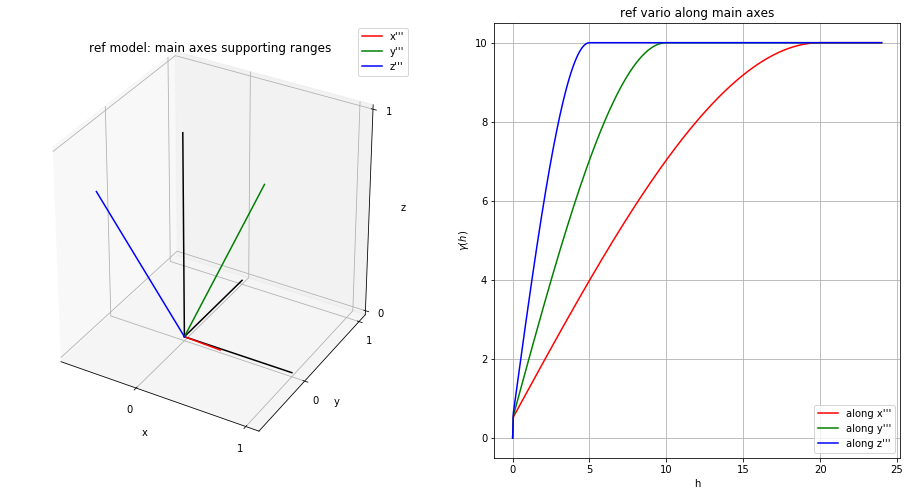

In [7]:
# Plot main axes supporting ranges and vario model curves along each main axis
fig = plt.figure(figsize=(16,8))

# ...plot main axes
fig.add_subplot(1,2,1, projection='3d')
cov_model_ref.plot_mrot(set_3d_subplot=False)
plt.title('ref model: main axes supporting ranges')

# ...plot variogram model curves along each main axis
fig.add_subplot(1,2,2)
cov_model_ref.plot_model_curves(vario=True)
plt.title('ref vario along main axes')
plt.show()

In [8]:
# Preparation for plotting reference simulation and data points

# fill image (Img class from geone.img) for view
im_ref = img.Img(nx, ny, nz, dx, dy, dz, ox, oy, oz, nv=1, val=ref)

# data_points: to be added to 3D plot
data_points = pv.PolyData(x)

# ... set color for data points according to their value
cmap = plt.get_cmap('terrain') # color map
cmin = im_ref.vmin()[0] # min value in ref
cmax = im_ref.vmax()[0] # max value in ref
data_points_col = [cmap((vv-cmin)/(cmax-cmin)) for vv in v] # color for data points according to their value
data_points['colors'] = data_points_col

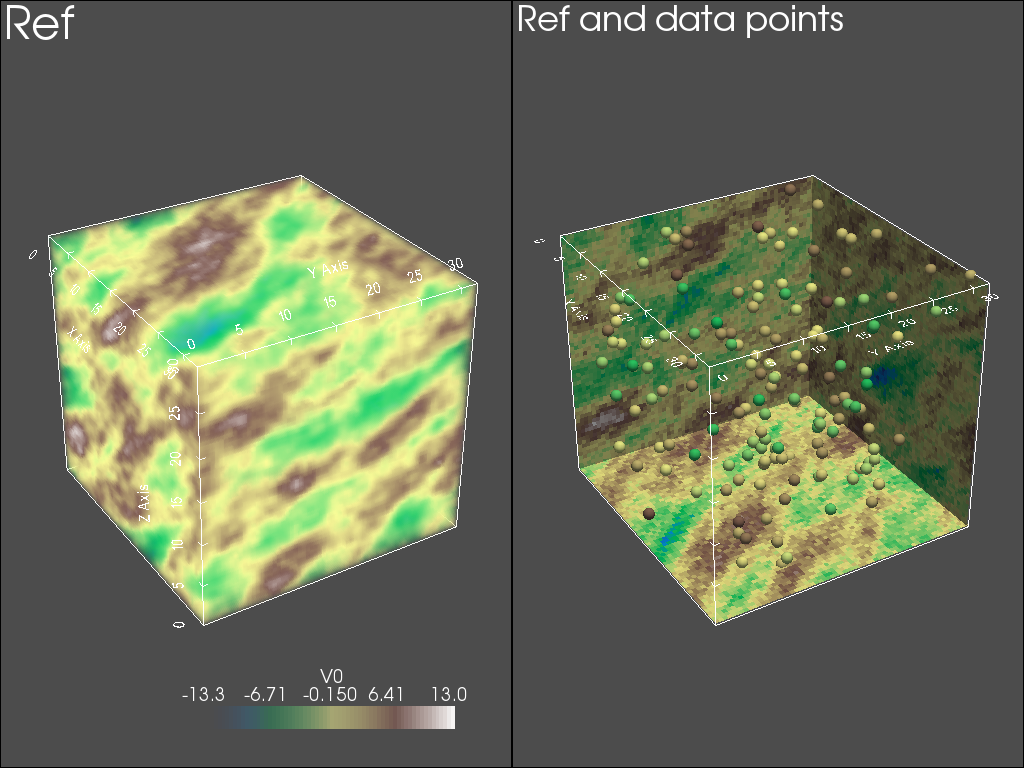

In [9]:
# Plot reference simulation and data points
pp = pv.Plotter(shape=(1,2))

# ... plot 
pp.subplot(0, 0)
imgplt3.drawImage3D_volume(im_ref, plotter=pp, cmap='terrain', cmin=cmin, cmax=cmax,
                           show_bounds=True, # show axes and ticks around the 3D box
                           text='Ref') # title
pp.subplot(0, 1)
imgplt3.drawImage3D_slice(im_ref, plotter=pp, cmap='terrain', cmin=cmin, cmax=cmax,
                          slice_normal_x=ox+0.5*dx,
                          slice_normal_y=oy+(ny-0.5)*dy,
                          slice_normal_z=oz+0.5*dz,
                          show_bounds=True, # show axes and ticks around the 3D box
                          text='Ref and data points') # title                          
pp.add_mesh(data_points, cmap=cmap, rgb=True, point_size=12., render_points_as_spheres=True)

pp.link_views()
pp.show(cpos=(165, -100, 115))

In [10]:
# Plot reference simulation and data points in an interactive figure
pp = pv.Plotter(shape=(1,2), notebook=False)

# ... plot 
pp.subplot(0, 0)
imgplt3.drawImage3D_volume(im_ref, plotter=pp, cmap='terrain', cmin=cmin, cmax=cmax,
                           show_bounds=True, # show axes and ticks around the 3D box
                           text='Ref') # title
pp.subplot(0, 1)
imgplt3.drawImage3D_slice(im_ref, plotter=pp, cmap='terrain', cmin=cmin, cmax=cmax,
                          slice_normal_x=ox+0.5*dx,
                          slice_normal_y=oy+(ny-0.5)*dy,
                          slice_normal_z=oz+0.5*dz,
                          show_bounds=True, # show axes and ticks around the 3D box
                          text='Ref and data points') # title
pp.add_mesh(data_points, cmap=cmap, rgb=True, point_size=12., render_points_as_spheres=True)

pp.link_views()
pp.show()

[(92.46800425399744, -95.83517442144515, 91.01237667637437),
 (16.25, 16.0, 15.0),
 (0.07571268233203587, 0.5952979315094717, 0.7999299734818247)]

## Start from a data set in 3D
- `n`: number of data points, 
- `x`: location of data points (2-dimensional array of shape `(n, 3)`, each row is a point),
- `v`: values at data points (1-dimensional array of length `n`).

Visualise the data set and the histogram of values.

In [11]:
# Set data_points
data_points = pv.PolyData(x)
data_points['data value'] = v

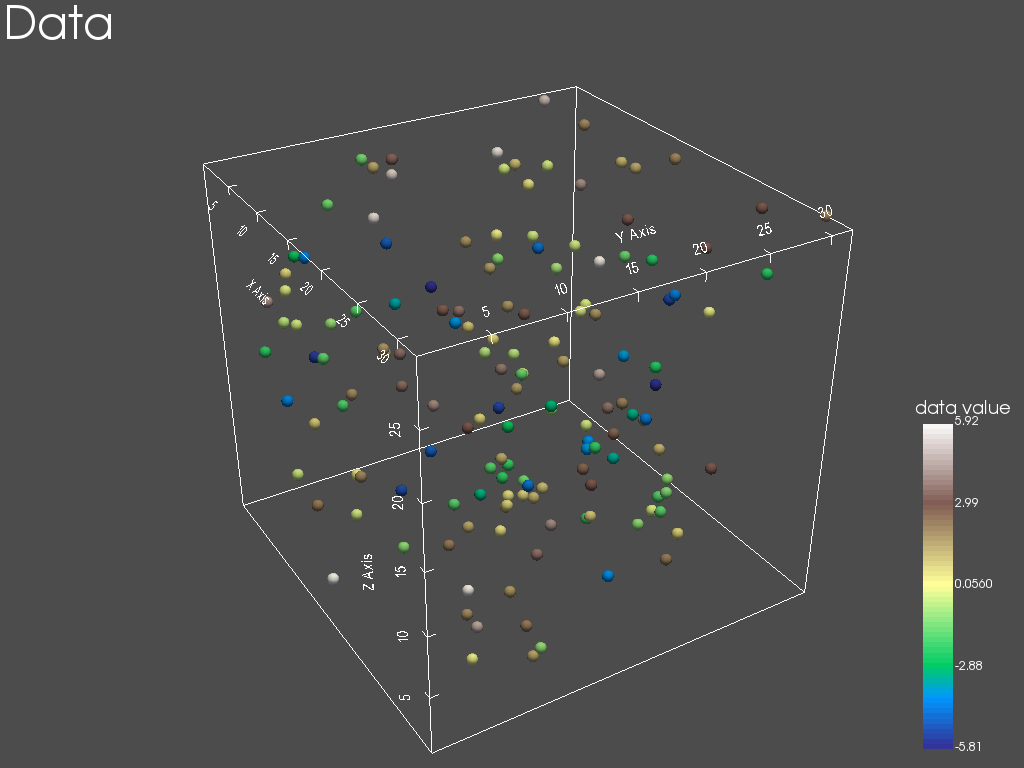

In [12]:
# Plot data points in 3D
pp = pv.Plotter()
pp.add_mesh(data_points, cmap=cmap, point_size=12., render_points_as_spheres=True, 
            scalar_bar_args={'vertical':True, 'title_font_size':18})
pp.add_mesh(data_points.outline())
pp.show_bounds()
pp.add_text('Data')
pp.show(cpos=(165, -100, 115))

In [13]:
# Plot data points in 3D in an interactive figure
pp = pv.Plotter(notebook=False)
pp.add_mesh(data_points, cmap=cmap, point_size=12., render_points_as_spheres=True, 
            scalar_bar_args={'vertical':True, 'title_font_size':18})
pp.add_mesh(data_points.outline())
pp.show_bounds()
pp.add_text('Data')
pp.show()

[(76.17374225087406, 75.92374225087406, 74.92374225087406),
 (16.25, 16.0, 15.0),
 (0.0, 0.0, 1.0)]

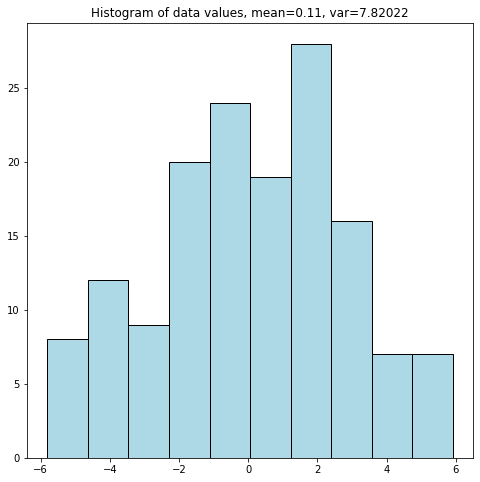

In [14]:
plt.figure(figsize=(8,8))
plt.hist(v, color='lightblue', edgecolor='black')
plt.title('Histogram of data values, mean={:.2g}, var={:2g}'.format(np.mean(v), np.var(v)))
plt.show()

### Model fitting
The function `covModel3D_fit` is used to fit a covariance model in 3D (class `covModel3D`).

This function takes as first argument the location of the data points, as second argument the values at the data points, and at third argument a covariance model in 3D with given type of elementary contributions and with parameters to fit set to `nan`. It returns the optimal covariance model and the vector of optimal parameters.

This function is based on the function `curve_fit` from `scipy.optimize` module. It fits the curve of the variogram model to the points $(h, \gamma(h))$, where $h$ is the lag between a pair of data points and $\gamma(h)$ is the half of the square of the difference of the values at these points. Hence, the fitting does not depend on the experimental variogram (see further), *i.e.* on the choice of direction or classes for the lags.

The function `covModel3D_fit` also takes the keyword argument `hmax`, which specifies the maximal distance between two data points to be integrated in the fitting. Note that a plot of the optimal model returned is made by default (keyword argument `make_plot=True`).

#### Bounds for parameters to fit
Bounds for parameters to fit can be specified to avoid meaningless optimal parameters returned (*e.g.* negative weight or range). Such bounds are given to the function `covModel3D_fit` (and then to the function `curve_fit` from `scipy.optimize`) via the keyword arguments `bounds=(<array of lower bounds>, <array of upper bounds>)`, where the arrays of lower / upper bounds have the same length as the vector of parameters to fit, with the $i-$th entry corresponding to the $i$-th parameter to fit (set to `nan`) in the covariance model passed as third argument. Note also that the keyword argument `p0` allows to specify a vector of initial parameters (see doc of function `curve_fit`).

In [15]:
cov_model_to_optimize = gcm.CovModel3D(
    elem=[('gaussian',    {'w':np.nan, 'r':[np.nan, np.nan, np.nan]}), # elementary contribution
          ('spherical',   {'w':np.nan, 'r':[np.nan, np.nan, np.nan]}), # elementary contribution
          ('exponential', {'w':np.nan, 'r':[np.nan, np.nan, np.nan]}), # elementary contribution
          ('nugget',      {'w':np.nan})                        # elementary contribution
         ], alpha=np.nan, beta=np.nan, gamma=np.nan, name='')

cov_model_opt, popt = gcm.covModel3D_fit(x, v, cov_model_to_optimize, #hmax=150,
    bounds=([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  .1, -90, -90, -90],  # min value for param. to fit
            [20, 30, 30, 30, 20, 30, 30, 30, 20, 30, 30, 30,   2,  90,  90,  90]), # max value for param. to fit
             # gaus. contr.,   sph. contr. ,   exp. contr. , nug., angles: alpha, beta, gamma
    make_plot=False)
cov_model_opt

Covariance model 3D: (Name = )
   4 elementary contribution(s)
   Elementary contribution 0: type : gaussian
      parameters:  w = 1.5439059954127507e-08,  r = [7.2424442496765735, 25.4592345659346, 5.116070794232457]
   Elementary contribution 1: type : spherical
      parameters:  w = 7.857269618630478,  r = [8.79895123274748, 29.999995582767575, 5.703598351839971]
   Elementary contribution 2: type : exponential
      parameters:  w = 5.800025842285344e-07,  r = [29.261742786568014, 3.26297718935676, 14.625674602979752]
   Elementary contribution 3: type : nugget
      parameters:  w = 0.14870009682504118
   Angles: alpha = -44.688194433055926 deg., beta = 7.157289630279509 deg., gamma = 43.9945142324671 deg.
   i.e.: the system Ox'''y''''z''', supporting the axes of the model (ranges),
         is obtained from the system Oxyz as follows:
         Oxyz      -- rotation of angle -alpha around Oz  --> Ox'y'z'
         Ox'y'z'   -- rotation of angle -beta  around Ox' --> Ox''y''z''
 

In [16]:
## Plot the covariance model obtained
##  slice orthogonal to main axes in a 3D block
#cov_model_opt.plot_model3d_slice()

In [17]:
## Plot the covariance model obtained in an interactive figure
##  slice orthogonal to main axes in a 3D block
#pp = pv.Plotter(notebook=False)
#cov_model_opt.plot_model3d_slice(plotter=pp)
#pp.show()

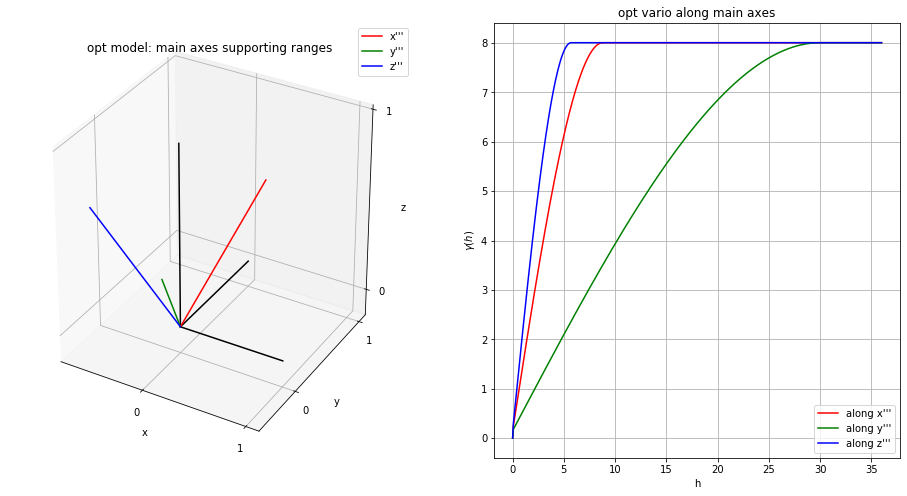

In [18]:
# Plot main axes supporting ranges and vario model curves along each main axis
fig = plt.figure(figsize=(16,8))

# ...plot main axes
fig.add_subplot(1,2,1, projection='3d')
cov_model_opt.plot_mrot(set_3d_subplot=False)
plt.title('opt model: main axes supporting ranges')

# ...plot variogram model curves along each main axis
fig.add_subplot(1,2,2)
cov_model_opt.plot_model_curves(vario=True)
plt.title('opt vario along main axes')
plt.show()

### Check with the experimental variograms in the main directions (derived from optimal angles retrieved)
The function `variogramExp3D` computes three directional exprimental variograms for a data set in 3D: one along each main axis ($x'''$, $y'''$ and $z'''$). The system $Ox'''y'''z'''$ is defined from the angle alpha, beta and gamma (keyword arguments `alpha`, `beta` and `gamma`) in the same way as for covariance model in 3D.

The keyword arguments `tol_dist` and `tol_angle` allow to control which pair of data points are taken into account in the two experimental variograms: a pair of points $(x(i), x(j))$ is in the directional variogram cloud along axis $x'''$ (resp. $y'''$, $z'''$) iff, given the lag vector $h = x(i) - x(j)$:
- the distance from the end of vector $h$ issued from origin to that axis is less than or equal to `tol_dist` and,
- the angle between $h$ and that axis is less than or equal to `tol_angle`.

The maximal distance between two data points to be integrated can be specified by the keyword argument `hmax` (vector of three floats one for each axis), and the classes can be customized by using the keyword arguments `ncla`, `cla_center`, `cla_length` (each one is a vector of length 3, specification for each axis), in a similar way as explained for the function `variogramExp1D` (see jupyter notebook `ex_vario_analysis_data1D`).

The function `variogramExp3D` returns three experimental variograms "unidimensional" (see function `variogramExp1D` and jupyter notebook `ex_vario_analysis_data1D`).

**Note:** the function `variogramCloud3D` allows to compute variogram clouds along the main axes in a similar way.

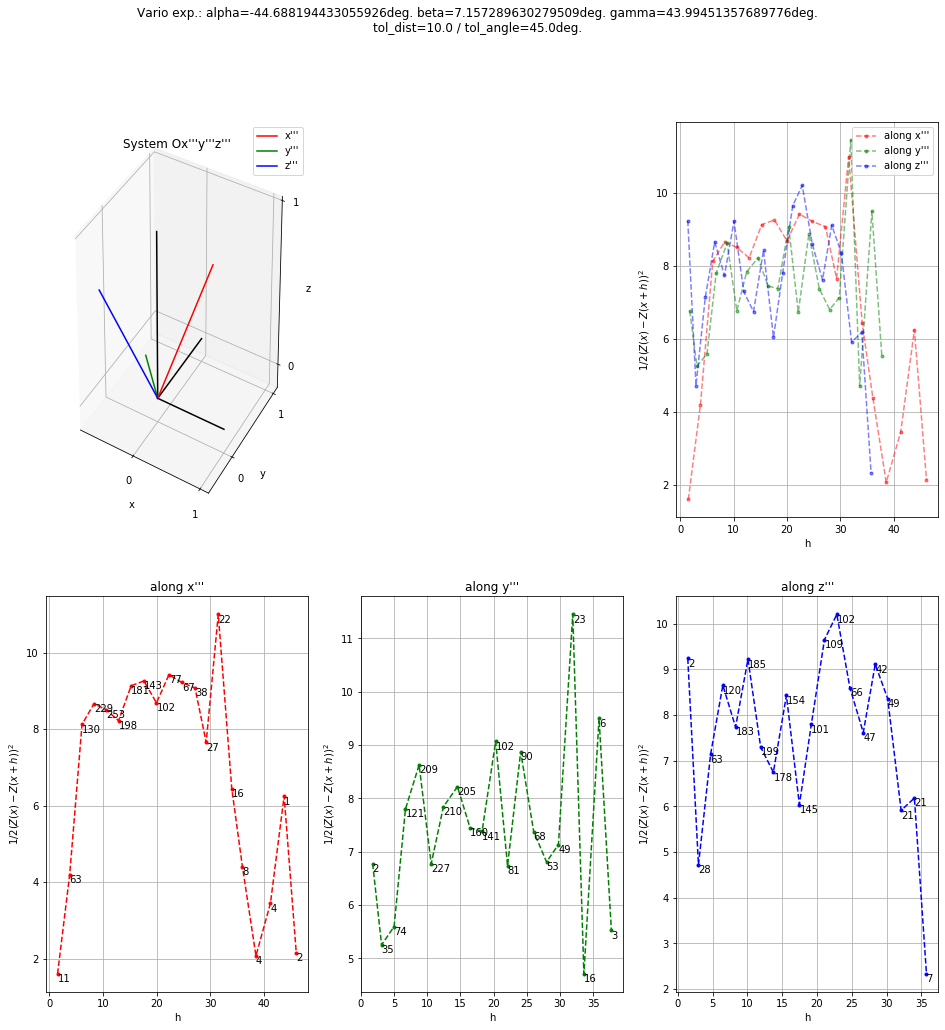

In [19]:
alpha_opt, beta_opt, gamma_opt = popt[-3:]
(hexp1, gexp1, cexp1), (hexp2, gexp2, cexp2), (hexp3, gexp3, cexp3) = gcm.variogramExp3D(x, v, 
    alpha=alpha_opt, beta=beta_opt, gamma=gamma_opt, ncla=(20,20,20), make_plot=True, figsize=(16,16))

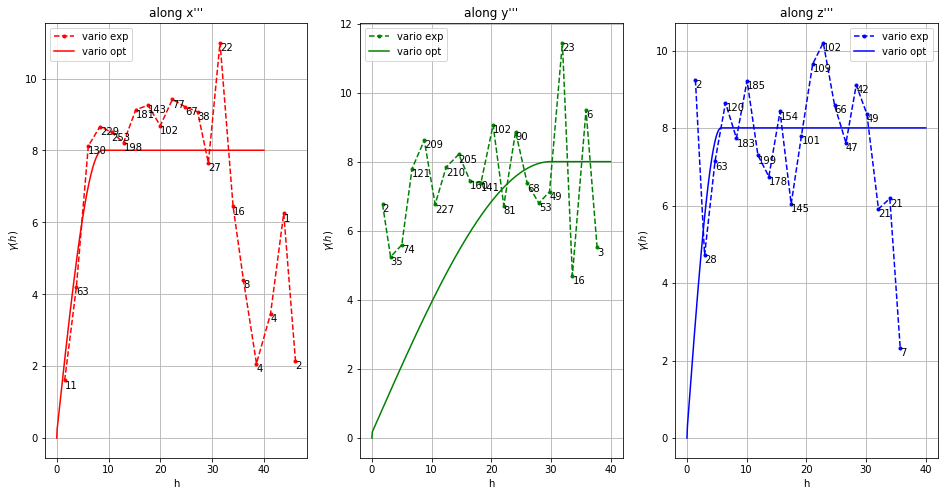

In [20]:
plt.subplots(1,3,figsize=(16,8))
plt.subplot(1,3,1)
gcm.plot_variogramExp1D(hexp1, gexp1, cexp1, c='red', label='vario exp')
cov_model_opt.plot_model_one_curve(vario=True, main_axis=1, hmax=40, c='red', label='vario opt')
plt.legend()
plt.title("along x'''")

plt.subplot(1,3,2)
gcm.plot_variogramExp1D(hexp2, gexp2, cexp2, c='green', label='vario exp')
cov_model_opt.plot_model_one_curve(vario=True, main_axis=2, hmax=40, c='green', label='vario opt')
plt.legend()
plt.title("along y'''")

plt.subplot(1,3,3)
gcm.plot_variogramExp1D(hexp3, gexp3, cexp3, c='blue', label='vario exp')
cov_model_opt.plot_model_one_curve(vario=True, main_axis=3, hmax=40, c='blue', label='vario opt')
plt.legend()
plt.title("along z'''")

plt.show()

Model does not pass test for sum of square of normalized error (chi2)!
   Sum of squares of normalized error = 213.0537722513261, above limit: 178.48535274685938


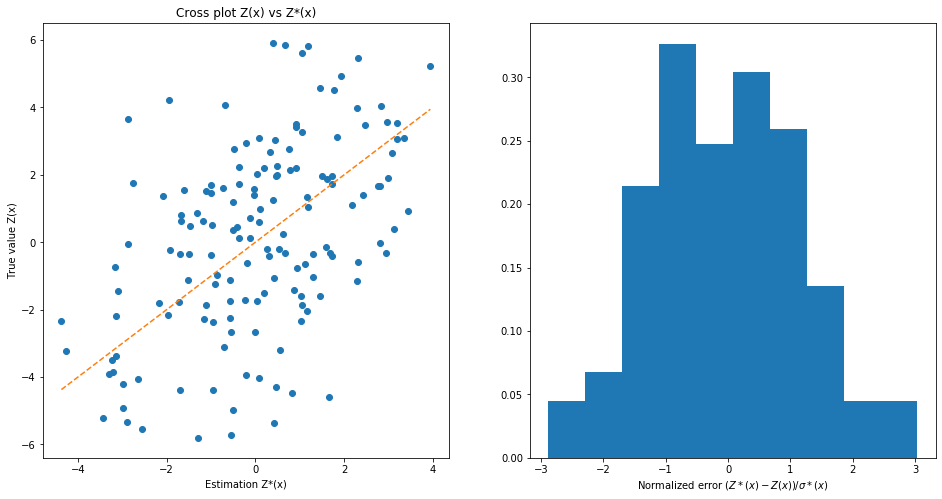

Test (1. normal law test for mean of normalized error) passed: True
Test (2. Chi2 test for sum of squares of normalized error) passed: False


In [21]:
test_passed = gcm.cross_valid_loo_ok(x, v, cov_model_opt, make_plot=True, figsize=(16,8))
plt.show()
print('\
Test (1. normal law test for mean of normalized error) passed: {}\n\
Test (2. Chi2 test for sum of squares of normalized error) passed: {}'.format(*test_passed))

The second test failed, then the covariance model should be rejected! Then, the search for a convenient covariance model continues.

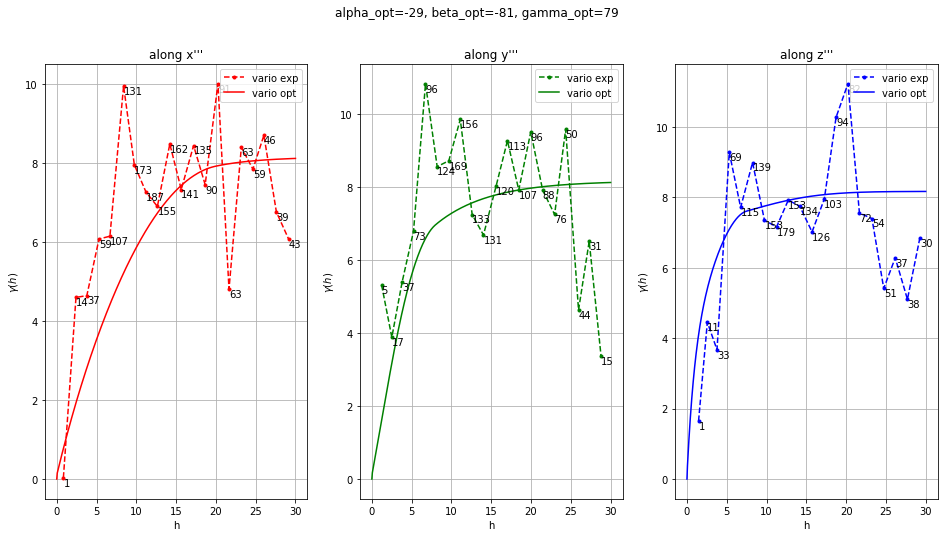

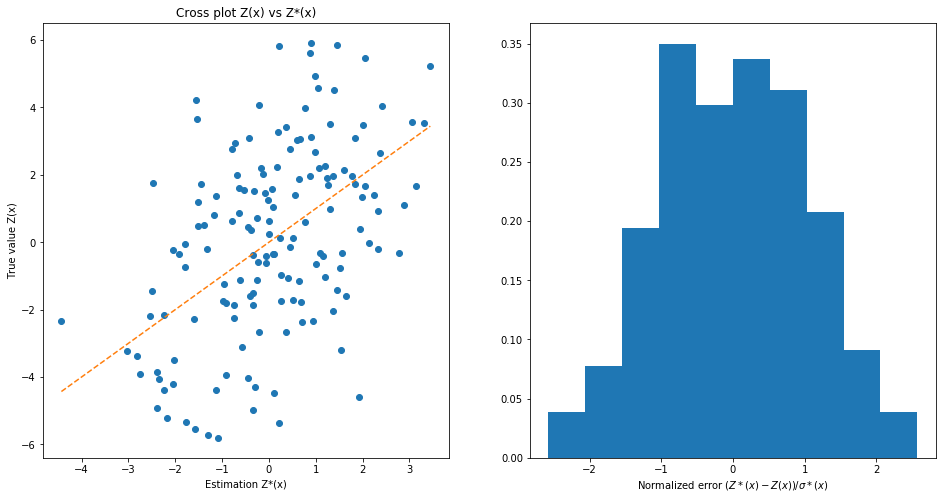

Test (1. normal law test for mean of normalized error) passed: True
Test (2. Chi2 test for sum of squares of normalized error) passed: True


Covariance model 3D: (Name = )
   4 elementary contribution(s)
   Elementary contribution 0: type : gaussian
      parameters:  w = 0.8490141922265452,  r = [19.99846329972967, 5.966104239940309, 19.995435007907297]
   Elementary contribution 1: type : spherical
      parameters:  w = 3.2348293350322104,  r = [19.999999999999996, 7.977449054503412, 7.48565357594717]
   Elementary contribution 2: type : exponential
      parameters:  w = 3.979636552107554,  r = [19.999999999999996, 19.999999999999996, 3.0127363182627964]
   Elementary contribution 3: type : nugget
      parameters:  w = 0.10000000000000002
   Angles: alpha = -28.758347680151726 deg., beta = -81.02703588598867 deg., gamma = 78.88477776944654 deg.
   i.e.: the system Ox'''y''''z''', supporting the axes of the model (ranges),
         is obtained from the system Oxyz as follows:
         Oxyz      -- rotation of angle -alpha around Oz  --> Ox'y'z'
         Ox'y'z'   -- rotation of angle -beta  around Ox' --> Ox''y''z''
   

In [22]:
# Model fitting 
cov_model_to_optimize = gcm.CovModel3D(
    elem=[('gaussian',    {'w':np.nan, 'r':[np.nan, np.nan, np.nan]}), # elementary contribution
          ('spherical',   {'w':np.nan, 'r':[np.nan, np.nan, np.nan]}), # elementary contribution
          ('exponential', {'w':np.nan, 'r':[np.nan, np.nan, np.nan]}), # elementary contribution
          ('nugget',      {'w':np.nan})                        # elementary contribution
         ], alpha=np.nan, beta=np.nan, gamma=np.nan, name='')

# New optim. while limiting the distance between pair of points to 30 (hmax=30)
# and limiting max ranges to 20 (instead of 30 above)
hmax = 30
cov_model_opt, popt = gcm.covModel3D_fit(x, v, cov_model_to_optimize, hmax=hmax,
    bounds=([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  .1, -90, -90, -90],  # min value for param. to fit
            [20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20,   2,  90,  90,  90]), # max value for param. to fit
             # gaus. contr.,   sph. contr. ,   exp. contr. , nug., angles: alpha, beta, gamma
    make_plot=False)

# Experimental variograms
alpha_opt, beta_opt, gamma_opt = popt[-3:]
(hexp1, gexp1, cexp1), (hexp2, gexp2, cexp2), (hexp3, gexp3, cexp3) = gcm.variogramExp3D(x, v, 
    alpha=alpha_opt, beta=beta_opt, gamma=gamma_opt, hmax=(hmax, hmax, hmax), ncla=(20,20,20), make_plot=False)

# Figure: optimal vario and exp. vario along main axes given by alpha_opt, beta_opt, gamma_opt
plt.subplots(1,3,figsize=(16,8))
plt.subplot(1,3,1)
gcm.plot_variogramExp1D(hexp1, gexp1, cexp1, c='red', label='vario exp')
cov_model_opt.plot_model_one_curve(vario=True, main_axis=1, hmax=hmax, c='red', label='vario opt')
plt.legend()
plt.title("along x'''")

plt.subplot(1,3,2)
gcm.plot_variogramExp1D(hexp2, gexp2, cexp2, c='green', label='vario exp')
cov_model_opt.plot_model_one_curve(vario=True, main_axis=2, hmax=hmax, c='green', label='vario opt')
plt.legend()
plt.title("along y'''")

plt.subplot(1,3,3)
gcm.plot_variogramExp1D(hexp3, gexp3, cexp3, c='blue', label='vario exp')
cov_model_opt.plot_model_one_curve(vario=True, main_axis=3, hmax=hmax, c='blue', label='vario opt')
plt.legend()
plt.title("along z'''")

plt.suptitle('alpha_opt={:.2g}, beta_opt={:.2g}, gamma_opt={:.2g}'.format(alpha_opt, beta_opt, gamma_opt))
plt.show()

# Cross-validation
test_passed = gcm.cross_valid_loo_ok(x, v, cov_model_opt, make_plot=True, figsize=(16,8))
plt.show()
print('\
Test (1. normal law test for mean of normalized error) passed: {}\n\
Test (2. Chi2 test for sum of squares of normalized error) passed: {}'.format(*test_passed))
cov_model_opt

**Note:** the following illustrations are similar to what is done in the jupyter notebook `ex_vario_analysis_data3D_1_omnidirectional`.

### Data interpolation by ordinary kriging

The function `ordinary_kriging(x, v, xu, cov_model)` returns the kriging estimates and standard deviation at location `xu`, given the data points located at `x` with value `v` and the covariance model `cov_model`.

For a given a data set (in 3D) and a covariance model in 1D, this latter defines an omni-directional covariance model.

For data in 3D:
- `x`: 2-dimensional array of shape `(n, 3)`, location of data points (each row is a point),
- `v`: 1-dimensional array of length `n`, values at data points,
- `xu`: 2-dimensional array of shape `(m, 3)` location of points where the interpolation is done. 

In return:
- `vu`: 1-dimensional array of length `m`, (ordinary) kriging estimates at location `xu`,
- `vu_std`: 1-dimensional array of length `m`, (ordinary) kriging standard deviation at location `xu`.

In [23]:
# Define points xu where to interpolate
# ... location of the 3D-grid used to build the data set (but it could be different)
xcu = ox + (np.arange(nx)+0.5)*dx # x-coordinates of points
ycu = oy + (np.arange(ny)+0.5)*dy # y-coordinates of points
zcu = oz + (np.arange(nz)+0.5)*dz # z-coordinates of points
zzcu, yycu, xxcu = np.meshgrid(zcu, ycu, xcu, indexing='ij')
xu = np.array((xxcu.reshape(-1), yycu.reshape(-1), zzcu.reshape(-1))).T # 2-dimensional array of shape nx*ny*nz x 3

# Ordinary kriging
vu, vu_std = gcm.ordinary_kriging(x, v, xu, cov_model_opt)
# vu:     1-dimensional array, kriging estimates at location xu
# vu_std: 1-dimensional array, kriging standard deviation at location xu

# Fill image (Img class from geone.img) for view
#   variable 0: ordinary kriging estimates
#   variable 1: ordinary kriging standard deviation
im_ok = img.Img(nx, ny, nz, dx, dy, dz, ox, oy, oz, nv=2, val=np.array((vu, vu_std)))

# Set data_points: to be added to 3D plot
data_points = pv.PolyData(x)

# ... set color for data points according to their value
cmap = plt.get_cmap('terrain') # color map
cmin = im_ok.vmin()[0] # min value in ordinary kriging estimates
cmax = im_ok.vmax()[0] # max value in ordinary kriging estimates
data_points_col = [cmap((vv-cmin)/(cmax-cmin)) for vv in v] # color for data points according to their value
data_points['colors'] = data_points_col

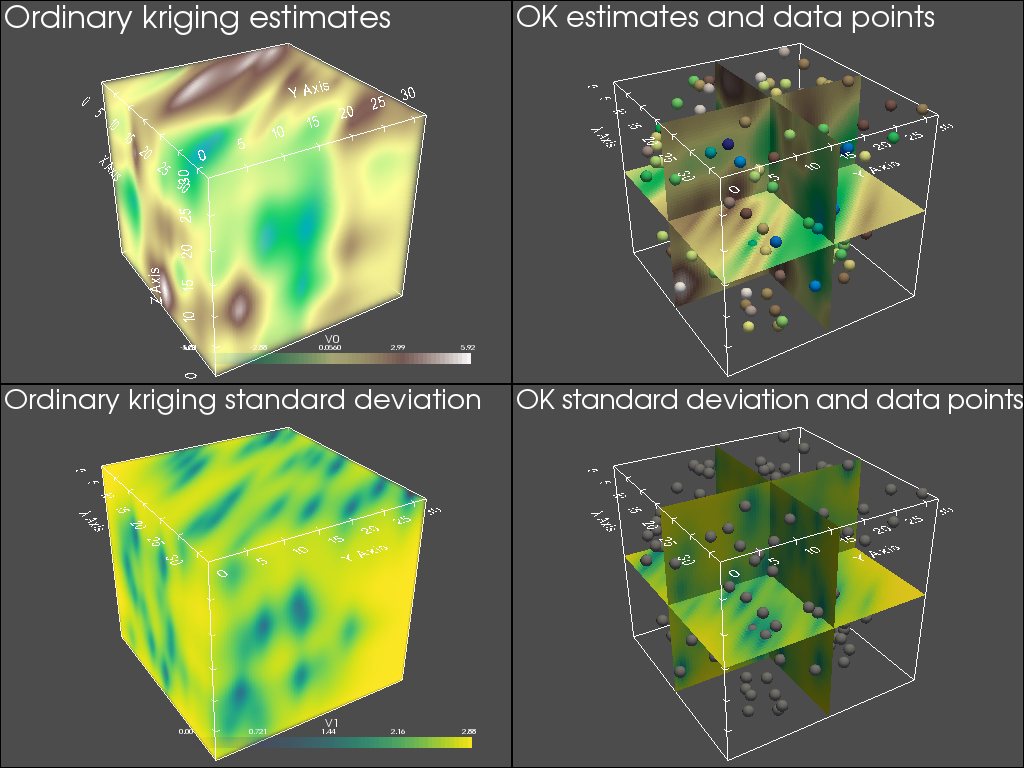

In [24]:
# Plot ordinary kriging estimates and standard deviation
pp = pv.Plotter(shape=(2,2))

# ... plot 
pp.subplot(0, 0)
imgplt3.drawImage3D_volume(im_ok, iv=0, plotter=pp, cmap='terrain', cmin=cmin, cmax=cmax,
                           show_bounds=True, # show axes and ticks around the 3D box
                           text='Ordinary kriging estimates') # title
pp.subplot(0, 1)
imgplt3.drawImage3D_slice(im_ok, iv=0, plotter=pp, cmap='terrain', cmin=cmin, cmax=cmax,
                          slice_normal_x=ox+(0.5+nx//2)*dx, # near central cell along x
                          slice_normal_y=oy+(0.5+ny//2)*dy, # near central cell along y
                          slice_normal_z=oz+(0.5+nz//2)*dz, # near central cell along z
                          show_bounds=True, # show axes and ticks around the 3D box
                          text='OK estimates and data points') # title                          
pp.add_mesh(data_points, rgb=True, point_size=12., render_points_as_spheres=True)

pp.subplot(1, 0)
imgplt3.drawImage3D_volume(im_ok, iv=1, plotter=pp, cmap='viridis',
                           show_bounds=True, # show axes and ticks around the 3D box
                           text='Ordinary kriging standard deviation') # title
pp.subplot(1, 1)
imgplt3.drawImage3D_slice(im_ok, iv=1, plotter=pp, cmap='viridis',
                          slice_normal_x=ox+(0.5+nx//2)*dx, # near central cell along x
                          slice_normal_y=oy+(0.5+ny//2)*dy, # near central cell along y
                          slice_normal_z=oz+(0.5+nz//2)*dz, # near central cell along z
                          show_bounds=True, # show axes and ticks around the 3D box
                          text='OK standard deviation and data points') # title                          
pp.add_mesh(data_points, color='gray', point_size=12., render_points_as_spheres=True)

pp.link_views()
pp.show(cpos=(165, -100, 115))

In [25]:
# Plot ordinary kriging estimates and standard deviation in an interactive figure
pp = pv.Plotter(shape=(2,2), notebook=False)

# ... plot 
pp.subplot(0, 0)
imgplt3.drawImage3D_volume(im_ok, iv=0, plotter=pp, cmap='terrain', cmin=cmin, cmax=cmax,
                           show_bounds=True, # show axes and ticks around the 3D box
                           text='Ordinary kriging estimates') # title
pp.subplot(0, 1)
imgplt3.drawImage3D_slice(im_ok, iv=0, plotter=pp, cmap='terrain', cmin=cmin, cmax=cmax,
                          slice_normal_x=ox+(0.5+nx//2)*dx, # near central cell along x
                          slice_normal_y=oy+(0.5+ny//2)*dy, # near central cell along y
                          slice_normal_z=oz+(0.5+nz//2)*dz, # near central cell along z
                          show_bounds=True, # show axes and ticks around the 3D box
                          text='OK estimates and data points') # title                          
pp.add_mesh(data_points, rgb=True, point_size=12., render_points_as_spheres=True)

pp.subplot(1, 0)
imgplt3.drawImage3D_volume(im_ok, iv=1, plotter=pp, cmap='viridis',
                           show_bounds=True, # show axes and ticks around the 3D box
                           text='Ordinary kriging standard deviation') # title
pp.subplot(1, 1)
imgplt3.drawImage3D_slice(im_ok, iv=1, plotter=pp, cmap='viridis',
                          slice_normal_x=ox+(0.5+nx//2)*dx, # near central cell along x
                          slice_normal_y=oy+(0.5+ny//2)*dy, # near central cell along y
                          slice_normal_z=oz+(0.5+nz//2)*dz, # near central cell along z
                          show_bounds=True, # show axes and ticks around the 3D box
                          text='OK standard deviation and data points') # title                          
pp.add_mesh(data_points, color='gray', point_size=12., render_points_as_spheres=True)

pp.link_views()
pp.show()

[(19.374446640710698, -58.94568548553631, 89.1338416618859),
 (16.25, 16.0, 15.0),
 (0.005580280424312191, 0.7033522826500057, 0.710819545989988)]

### Simple kriging (comparison)
Assuming the data (variable) stationary and specifying a constant mean (computed on the data set), the function `krige3D` (from `geone.grf` module, see jupyter notebook `ex_grf_3d`) can be used to compute simple krging estimates and standard deviation.

**Note:** a varying mean can also be specified.

In [26]:
vu_sk, vu_sk_std = grf.krige3D(x, v, cov_model_opt, (nx, ny, nz), (dx, dy, dz), (ox, oy, oz), 
                               mean=np.mean(v), printInfo=False)

# Fill image (Img class from geone.img) for view
#   variable 0: simple kriging estimates
#   variable 1: simple kriging standard deviation
im_sk = img.Img(nx, ny, nz, dx, dy, dz, ox, oy, oz, nv=2, val=np.array((vu_sk, vu_sk_std)))

# Set data_points: to be added to 3D plot
data_points = pv.PolyData(x)

# ... set color for data points according to their value
cmap = plt.get_cmap('terrain') # color map
cmin = im_sk.vmin()[0] # min value in simple kriging estimates
cmax = im_sk.vmax()[0] # max value in simple kriging estimates
data_points_col = [cmap((vv-cmin)/(cmax-cmin)) for vv in v] # color for data points according to their value
data_points['colors'] = data_points_col

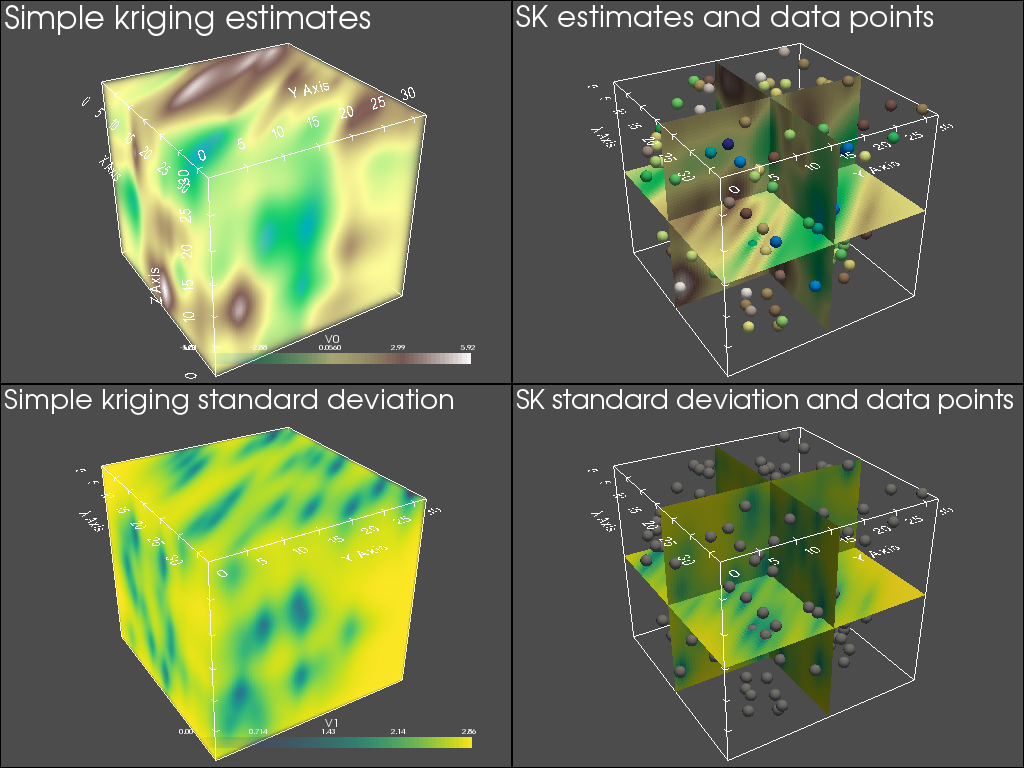

In [27]:
# Plot simple kriging estimates and standard deviation
pp = pv.Plotter(shape=(2,2))

# ... plot 
pp.subplot(0, 0)
imgplt3.drawImage3D_volume(im_sk, iv=0, plotter=pp, cmap='terrain', cmin=cmin, cmax=cmax,
                           show_bounds=True, # show axes and ticks around the 3D box
                           text='Simple kriging estimates') # title
pp.subplot(0, 1)
imgplt3.drawImage3D_slice(im_sk, iv=0, plotter=pp, cmap='terrain', cmin=cmin, cmax=cmax,
                          slice_normal_x=ox+(0.5+nx//2)*dx, # near central cell along x
                          slice_normal_y=oy+(0.5+ny//2)*dy, # near central cell along y
                          slice_normal_z=oz+(0.5+nz//2)*dz, # near central cell along z
                          show_bounds=True, # show axes and ticks around the 3D box
                          text='SK estimates and data points') # title                          
pp.add_mesh(data_points, rgb=True, point_size=12., render_points_as_spheres=True)

pp.subplot(1, 0)
imgplt3.drawImage3D_volume(im_sk, iv=1, plotter=pp, cmap='viridis',
                           show_bounds=True, # show axes and ticks around the 3D box
                           text='Simple kriging standard deviation') # title
pp.subplot(1, 1)
imgplt3.drawImage3D_slice(im_sk, iv=1, plotter=pp, cmap='viridis',
                          slice_normal_x=ox+(0.5+nx//2)*dx, # near central cell along x
                          slice_normal_y=oy+(0.5+ny//2)*dy, # near central cell along y
                          slice_normal_z=oz+(0.5+nz//2)*dz, # near central cell along z
                          show_bounds=True, # show axes and ticks around the 3D box
                          text='SK standard deviation and data points') # title                          
pp.add_mesh(data_points, color='gray', point_size=12., render_points_as_spheres=True)

pp.link_views()
pp.show(cpos=(165, -100, 115))

In [28]:
# Plot simple kriging estimates and standard deviation in an interactive figure
pp = pv.Plotter(shape=(2,2), notebook=False)

# ... plot 
pp.subplot(0, 0)
imgplt3.drawImage3D_volume(im_sk, iv=0, plotter=pp, cmap='terrain', cmin=cmin, cmax=cmax,
                           show_bounds=True, # show axes and ticks around the 3D box
                           text='Simple kriging estimates') # title
pp.subplot(0, 1)
imgplt3.drawImage3D_slice(im_sk, iv=0, plotter=pp, cmap='terrain', cmin=cmin, cmax=cmax,
                          slice_normal_x=ox+(0.5+nx//2)*dx, # near central cell along x
                          slice_normal_y=oy+(0.5+ny//2)*dy, # near central cell along y
                          slice_normal_z=oz+(0.5+nz//2)*dz, # near central cell along z
                          show_bounds=True, # show axes and ticks around the 3D box
                          text='SK estimates and data points') # title                          
pp.add_mesh(data_points, rgb=True, point_size=12., render_points_as_spheres=True)

pp.subplot(1, 0)
imgplt3.drawImage3D_volume(im_sk, iv=1, plotter=pp, cmap='viridis',
                           show_bounds=True, # show axes and ticks around the 3D box
                           text='Simple kriging standard deviation') # title
pp.subplot(1, 1)
imgplt3.drawImage3D_slice(im_sk, iv=1, plotter=pp, cmap='viridis',
                          slice_normal_x=ox+(0.5+nx//2)*dx, # near central cell along x
                          slice_normal_y=oy+(0.5+ny//2)*dy, # near central cell along y
                          slice_normal_z=oz+(0.5+nz//2)*dz, # near central cell along z
                          show_bounds=True, # show axes and ticks around the 3D box
                          text='SK standard deviation and data points') # title                          
pp.add_mesh(data_points, color='gray', point_size=12., render_points_as_spheres=True)

pp.link_views()
pp.show()

[(17.59107942718854, -53.029752881806665, 94.72163534639661),
 (16.25, 16.0, 15.0),
 (0.01284039023763294, 0.7560260989329182, 0.6544155118201426)]

In [29]:
# Difference of simple kriging - ordinary kriging
im_diff = img.copyImg(im_sk)
im_diff.val = im_sk.val - im_ok.val

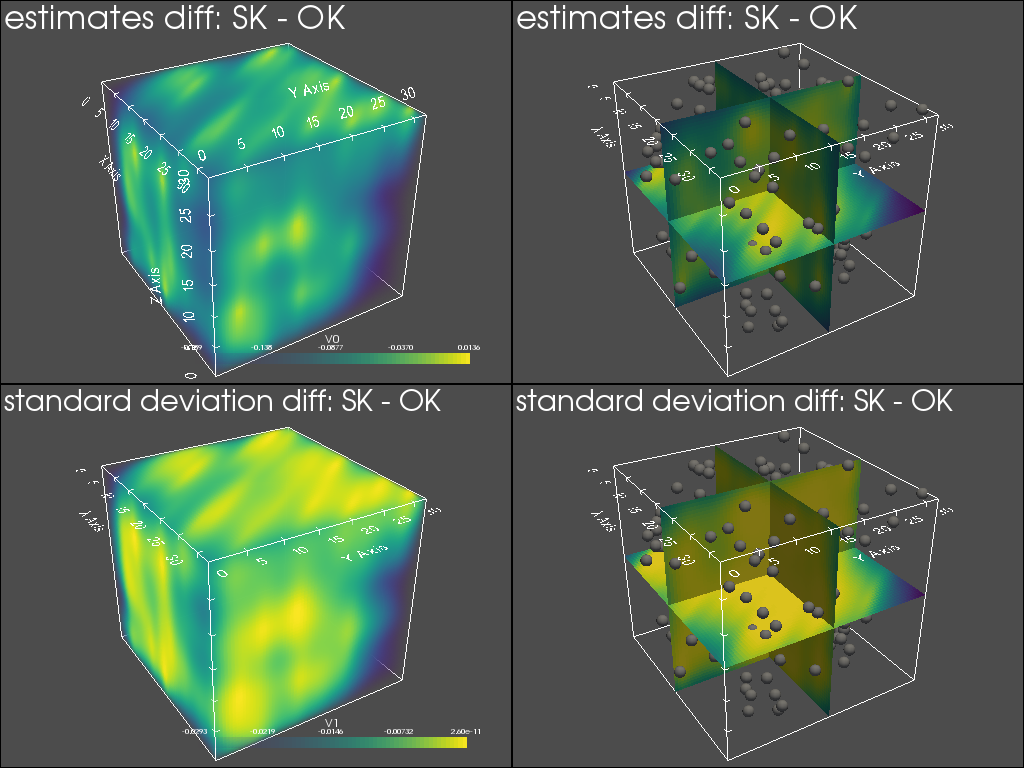

In [30]:
# Plot
pp = pv.Plotter(shape=(2,2))

# ... plot 
pp.subplot(0, 0)
imgplt3.drawImage3D_volume(im_diff, iv=0, plotter=pp,
                           show_bounds=True, # show axes and ticks around the 3D box
                           text='estimates diff: SK - OK') # title
pp.subplot(0, 1)
imgplt3.drawImage3D_slice(im_diff, iv=0, plotter=pp,
                          slice_normal_x=ox+(0.5+nx//2)*dx, # near central cell along x
                          slice_normal_y=oy+(0.5+ny//2)*dy, # near central cell along y
                          slice_normal_z=oz+(0.5+nz//2)*dz, # near central cell along z
                          show_bounds=True, # show axes and ticks around the 3D box
                          text='estimates diff: SK - OK') # title                          
pp.add_mesh(data_points, color='gray', point_size=12., render_points_as_spheres=True)

pp.subplot(1, 0)
imgplt3.drawImage3D_volume(im_diff, iv=1, plotter=pp,
                           show_bounds=True, # show axes and ticks around the 3D box
                           text='standard deviation diff: SK - OK') # title
pp.subplot(1, 1)
imgplt3.drawImage3D_slice(im_diff, iv=1, plotter=pp,
                          slice_normal_x=ox+(0.5+nx//2)*dx, # near central cell along x
                          slice_normal_y=oy+(0.5+ny//2)*dy, # near central cell along y
                          slice_normal_z=oz+(0.5+nz//2)*dz, # near central cell along z
                          show_bounds=True, # show axes and ticks around the 3D box
                          text='standard deviation diff: SK - OK') # title                          
pp.add_mesh(data_points, color='gray', point_size=12., render_points_as_spheres=True)

pp.link_views()
pp.show(cpos=(165, -100, 115))

In [31]:
# Plot in an interactive figure
pp = pv.Plotter(shape=(2,2), notebook=False)

# ... plot 
pp.subplot(0, 0)
imgplt3.drawImage3D_volume(im_diff, iv=0, plotter=pp,
                           show_bounds=True, # show axes and ticks around the 3D box
                           text='estimates diff: SK - OK') # title
pp.subplot(0, 1)
imgplt3.drawImage3D_slice(im_diff, iv=0, plotter=pp,
                          slice_normal_x=ox+(0.5+nx//2)*dx, # near central cell along x
                          slice_normal_y=oy+(0.5+ny//2)*dy, # near central cell along y
                          slice_normal_z=oz+(0.5+nz//2)*dz, # near central cell along z
                          show_bounds=True, # show axes and ticks around the 3D box
                          text='estimates diff: SK - OK') # title                          
pp.add_mesh(data_points, color='gray', point_size=12., render_points_as_spheres=True)

pp.subplot(1, 0)
imgplt3.drawImage3D_volume(im_diff, iv=1, plotter=pp,
                           show_bounds=True, # show axes and ticks around the 3D box
                           text='standard deviation diff: SK - OK') # title
pp.subplot(1, 1)
imgplt3.drawImage3D_slice(im_diff, iv=1, plotter=pp,
                          slice_normal_x=ox+(0.5+nx//2)*dx, # near central cell along x
                          slice_normal_y=oy+(0.5+ny//2)*dy, # near central cell along y
                          slice_normal_z=oz+(0.5+nz//2)*dz, # near central cell along z
                          show_bounds=True, # show axes and ticks around the 3D box
                          text='standard deviation diff: SK - OK') # title                          
pp.add_mesh(data_points, color='gray', point_size=12., render_points_as_spheres=True)

pp.link_views()
pp.show()

[(24.291210954417192, -57.147447530278555, 90.54623925417363),
 (16.25, 16.0, 15.0),
 (-0.09234521233590458, 0.7104207965601304, 0.6976923774655319)]

### Conditional simulation using the function `grf3D`
Specifying the same mean, the function `grf3D` (from `geone.grf` module, see jupyter notebook `ex_grf_3d`) can be used to generate conditional realizations (based on simple kriging).

In [32]:
# Simulation
np.random.seed(293)
nreal = 3
sim = grf.grf3D(cov_model_opt, (nx, ny, nz), (dx, dy, dz), (ox, oy, oz), 
                x=x, v=v, nreal=nreal, printInfo=False) # 4d-array of shape nreal x nz x ny x nx

# Fill image (Img class from geone.img) for view
im_sim = img.Img(nx, ny, nz, dx, dy, dz, ox, oy, oz, nv=nreal, val=sim)

im_vmin = min(np.min(im_sim.vmin()), im_ref.vmin()[0]) # min over all real and ref. sim
im_vmax = max(np.max(im_sim.vmax()), im_ref.vmax()[0]) # max over all real and ref. sim


# ... set color for data points according to their value
cmap = plt.get_cmap('terrain') # color map
cmin = im_vmin
cmax = im_vmax
data_points_col = [cmap((vv-cmin)/(cmax-cmin)) for vv in v] # color for data points according to their value
data_points['colors'] = data_points_col

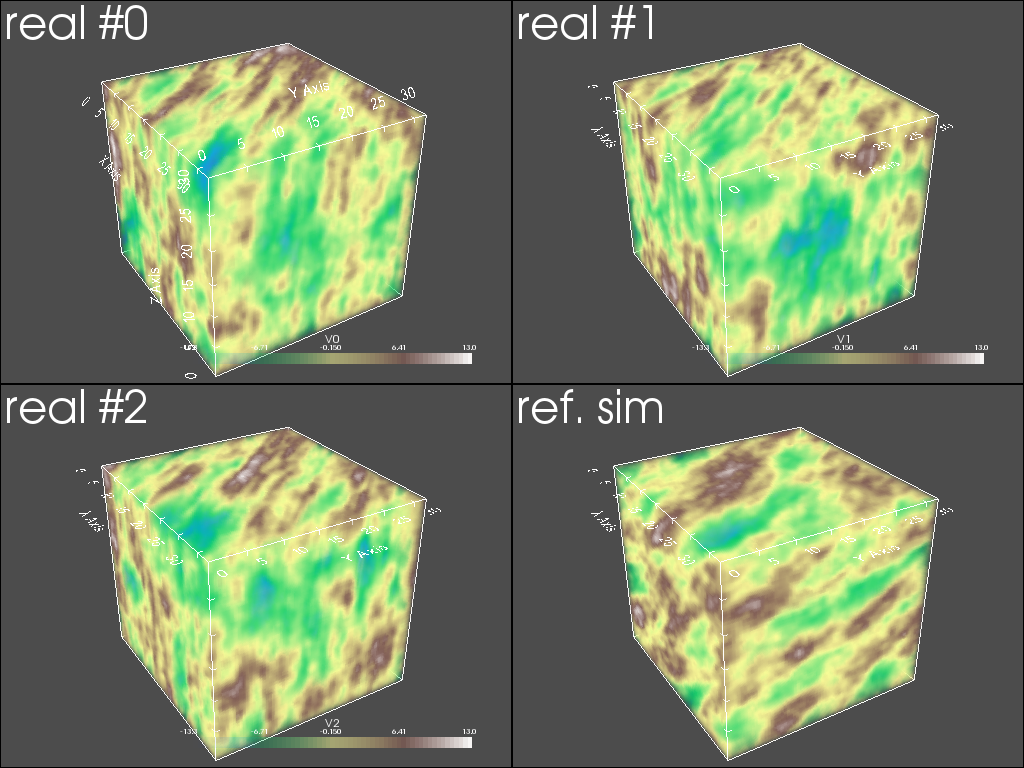

In [33]:
# Plot (volume)
pp = pv.Plotter(shape=(2,2))

# ... plot 
pp.subplot(0, 0)
i = 0 # real index
imgplt3.drawImage3D_volume(im_sim, iv=i, plotter=pp, cmap='terrain', cmin=cmin, cmax=cmax,
                           show_bounds=True, # show axes and ticks around the 3D box
                           text='real #{}'.format(i)) # title

pp.subplot(0, 1)
i = 1 # real index
imgplt3.drawImage3D_volume(im_sim, iv=i, plotter=pp, cmap='terrain', cmin=cmin, cmax=cmax,
                           show_bounds=True, # show axes and ticks around the 3D box
                           text='real #{}'.format(i)) # title
pp.subplot(1, 0)
i = 2 # real index
imgplt3.drawImage3D_volume(im_sim, iv=i, plotter=pp, cmap='terrain', cmin=cmin, cmax=cmax,
                           show_bounds=True, # show axes and ticks around the 3D box
                           text='real #{}'.format(i)) # title

pp.subplot(1, 1)
imgplt3.drawImage3D_volume(im_ref, plotter=pp, cmap='terrain', cmin=cmin, cmax=cmax,
                           show_bounds=True, # show axes and ticks around the 3D box
                           text='ref. sim') # title

pp.link_views()
pp.show(cpos=(165, -100, 115))

In [34]:
# Plot (volume) in an interactive figure
pp = pv.Plotter(shape=(2,2), notebook=False)

# ... plot 
pp.subplot(0, 0)
i = 0 # real index
imgplt3.drawImage3D_volume(im_sim, iv=i, plotter=pp, cmap='terrain', cmin=cmin, cmax=cmax,
                           show_bounds=True, # show axes and ticks around the 3D box
                           text='real #{}'.format(i)) # title

pp.subplot(0, 1)
i = 1 # real index
imgplt3.drawImage3D_volume(im_sim, iv=i, plotter=pp, cmap='terrain', cmin=cmin, cmax=cmax,
                           show_bounds=True, # show axes and ticks around the 3D box
                           text='real #{}'.format(i)) # title
pp.subplot(1, 0)
i = 2 # real index
imgplt3.drawImage3D_volume(im_sim, iv=i, plotter=pp, cmap='terrain', cmin=cmin, cmax=cmax,
                           show_bounds=True, # show axes and ticks around the 3D box
                           text='real #{}'.format(i)) # title

pp.subplot(1, 1)
imgplt3.drawImage3D_volume(im_ref, plotter=pp, cmap='terrain', cmin=cmin, cmax=cmax,
                           show_bounds=True, # show axes and ticks around the 3D box
                           text='ref. sim') # title

pp.link_views()
pp.show()

[(28.058249461798766, -69.43578164550895, 75.69379604643291),
 (16.25, 16.0, 15.0),
 (0.031979504046655796, 0.5817775828553131, 0.8127189892010396)]

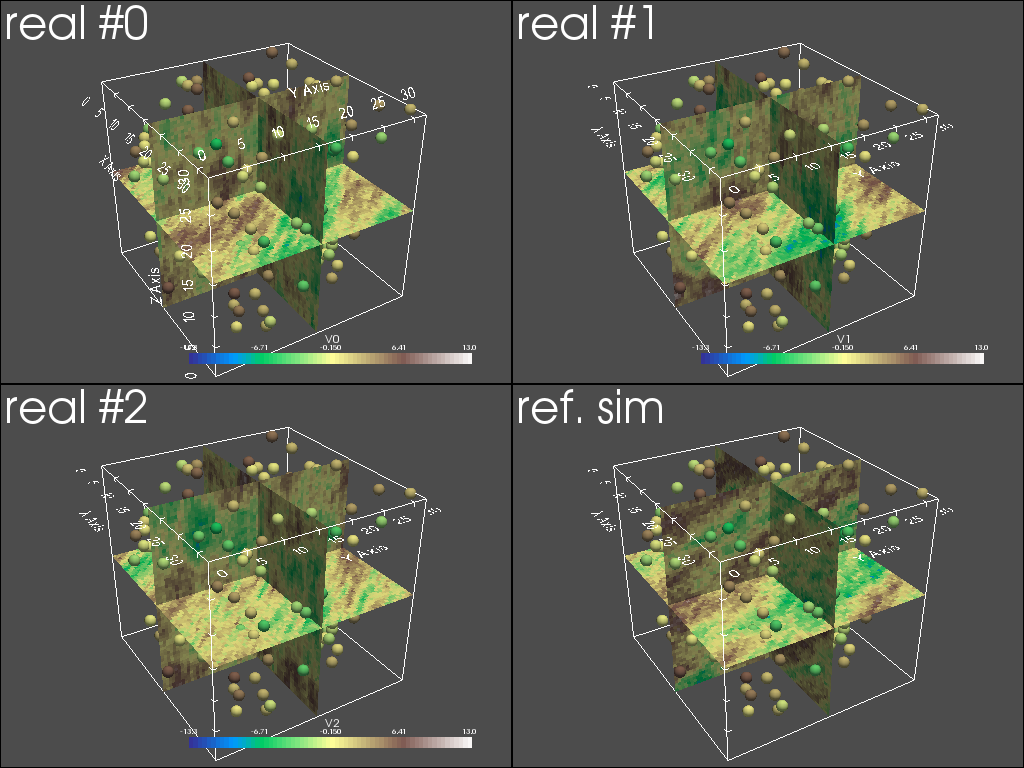

In [35]:
# Plot (slices in 3D block)
pp = pv.Plotter(shape=(2,2))

# ... plot 
pp.subplot(0, 0)
i = 0 # real index
imgplt3.drawImage3D_slice(im_sim, iv=i, plotter=pp, cmap='terrain', cmin=cmin, cmax=cmax,
                          slice_normal_x=ox+(0.5+nx//2)*dx, # near central cell along x
                          slice_normal_y=oy+(0.5+ny//2)*dy, # near central cell along y
                          slice_normal_z=oz+(0.5+nz//2)*dz, # near central cell along z
                          show_bounds=True, # show axes and ticks around the 3D box
                          text='real #{}'.format(i)) # title
pp.add_mesh(data_points, rgb=True, point_size=12., render_points_as_spheres=True)

pp.subplot(0, 1)
i = 1 # real index
imgplt3.drawImage3D_slice(im_sim, iv=i, plotter=pp, cmap='terrain', cmin=cmin, cmax=cmax,
                          slice_normal_x=ox+(0.5+nx//2)*dx, # near central cell along x
                          slice_normal_y=oy+(0.5+ny//2)*dy, # near central cell along y
                          slice_normal_z=oz+(0.5+nz//2)*dz, # near central cell along z
                          show_bounds=True, # show axes and ticks around the 3D box
                          text='real #{}'.format(i)) # title
pp.add_mesh(data_points, rgb=True, point_size=12., render_points_as_spheres=True)

pp.subplot(1, 0)
i = 2 # real index
imgplt3.drawImage3D_slice(im_sim, iv=i, plotter=pp, cmap='terrain', cmin=cmin, cmax=cmax,
                          slice_normal_x=ox+(0.5+nx//2)*dx, # near central cell along x
                          slice_normal_y=oy+(0.5+ny//2)*dy, # near central cell along y
                          slice_normal_z=oz+(0.5+nz//2)*dz, # near central cell along z
                          show_bounds=True, # show axes and ticks around the 3D box
                          text='real #{}'.format(i)) # title
pp.add_mesh(data_points, rgb=True, point_size=12., render_points_as_spheres=True)

pp.subplot(1, 1)
imgplt3.drawImage3D_slice(im_ref, plotter=pp, cmap='terrain', cmin=cmin, cmax=cmax,
                          slice_normal_x=ox+(0.5+nx//2)*dx, # near central cell along x
                          slice_normal_y=oy+(0.5+ny//2)*dy, # near central cell along y
                          slice_normal_z=oz+(0.5+nz//2)*dz, # near central cell along z
                          show_bounds=True, # show axes and ticks around the 3D box
                          text='ref. sim') # title
pp.add_mesh(data_points, rgb=True, point_size=12., render_points_as_spheres=True)

pp.link_views()
pp.show(cpos=(165, -100, 115))

In [36]:
# Plot (slices in 3D block) in an interactive figure
pp = pv.Plotter(shape=(2,2), notebook=False)

# ... plot 
pp.subplot(0, 0)
i = 0 # real index
imgplt3.drawImage3D_slice(im_sim, iv=i, plotter=pp, cmap='terrain', cmin=cmin, cmax=cmax,
                          slice_normal_x=ox+(0.5+nx//2)*dx, # near central cell along x
                          slice_normal_y=oy+(0.5+ny//2)*dy, # near central cell along y
                          slice_normal_z=oz+(0.5+nz//2)*dz, # near central cell along z
                          show_bounds=True, # show axes and ticks around the 3D box
                          text='real #{}'.format(i)) # title
pp.add_mesh(data_points, rgb=True, point_size=12., render_points_as_spheres=True)

pp.subplot(0, 1)
i = 1 # real index
imgplt3.drawImage3D_slice(im_sim, iv=i, plotter=pp, cmap='terrain', cmin=cmin, cmax=cmax,
                          slice_normal_x=ox+(0.5+nx//2)*dx, # near central cell along x
                          slice_normal_y=oy+(0.5+ny//2)*dy, # near central cell along y
                          slice_normal_z=oz+(0.5+nz//2)*dz, # near central cell along z
                          show_bounds=True, # show axes and ticks around the 3D box
                          text='real #{}'.format(i)) # title
pp.add_mesh(data_points, rgb=True, point_size=12., render_points_as_spheres=True)

pp.subplot(1, 0)
i = 2 # real index
imgplt3.drawImage3D_slice(im_sim, iv=i, plotter=pp, cmap='terrain', cmin=cmin, cmax=cmax,
                          slice_normal_x=ox+(0.5+nx//2)*dx, # near central cell along x
                          slice_normal_y=oy+(0.5+ny//2)*dy, # near central cell along y
                          slice_normal_z=oz+(0.5+nz//2)*dz, # near central cell along z
                          show_bounds=True, # show axes and ticks around the 3D box
                          text='real #{}'.format(i)) # title
pp.add_mesh(data_points, rgb=True, point_size=12., render_points_as_spheres=True)

pp.subplot(1, 1)
imgplt3.drawImage3D_slice(im_ref, plotter=pp, cmap='terrain', cmin=cmin, cmax=cmax,
                          slice_normal_x=ox+(0.5+nx//2)*dx, # near central cell along x
                          slice_normal_y=oy+(0.5+ny//2)*dy, # near central cell along y
                          slice_normal_z=oz+(0.5+nz//2)*dz, # near central cell along z
                          show_bounds=True, # show axes and ticks around the 3D box
                          text='ref. sim') # title
pp.add_mesh(data_points, rgb=True, point_size=12., render_points_as_spheres=True)

pp.link_views()
pp.show()

[(75.97522024294395, -56.73948433194183, 62.58476547501542),
 (16.25, 16.0, 15.0),
 (0.003838205531045774, 0.5496465182177366, 0.8353885163140684)]

The retained optimal covariance model has angles differing from those of the reference covariance model (which is considered unknown!), this is why the orientations of the structures slightly differ comparing the realizations above and the reference.

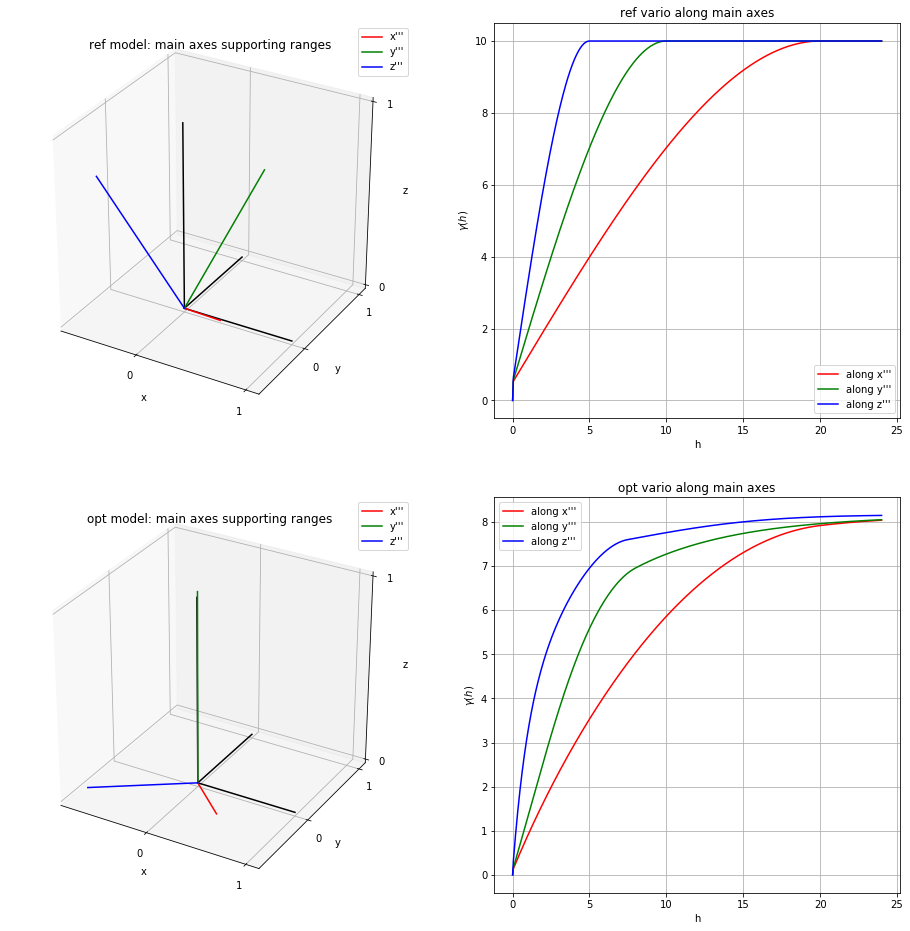

In [37]:
# Comparison of "optimal model" and "reference model"
fig = plt.figure(figsize=(16,16))

# ...plot main axes (ref model)
fig.add_subplot(2,2,1, projection='3d')
cov_model_ref.plot_mrot(set_3d_subplot=False)
plt.title('ref model: main axes supporting ranges')

# ...plot variogram model curves along each main axis (ref model)
fig.add_subplot(2,2,2)
cov_model_ref.plot_model_curves(vario=True)
plt.title('ref vario along main axes')

# ...plot main axes (opt model)
fig.add_subplot(2,2,3, projection='3d')
cov_model_opt.plot_mrot(set_3d_subplot=False)
plt.title('opt model: main axes supporting ranges')

# ...plot variogram model curves along each main axis (opt model)
fig.add_subplot(2,2,4)
cov_model_opt.plot_model_curves(vario=True)
plt.title('opt vario along main axes')

plt.show()